(4, 3060)
(3060,)


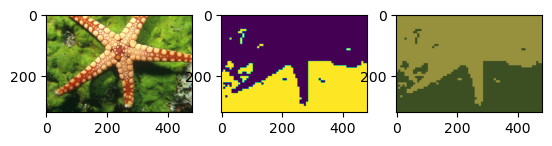

In [7]:
# CS5487 demo script for Programming Assignment 2
#
# The script has been tested with python 2.7.6
#
# It requires the following modules:
#   numpy 1.8.1
#   matplotlib v1.3.1
#   scipy 0.14.0
#   Image (python image library)

import pa2
import numpy as np
import pylab as pl
from PIL import Image
import scipy.io as sio

def demo():
    import scipy.cluster.vq as vq

    ## load and show image
    img = Image.open('images/12003.jpg')
    pl.subplot(1,3,1)
    pl.imshow(img)
    
    ## extract features from image (step size = 7)
    X,L = pa2.getfeatures(img, 7)

    print(X.shape)
    ## Call kmeans function in scipy.  You need to write this yourself!
    C,Y = vq.kmeans2(vq.whiten(X.T), 2, iter=1000, minit='random')
    Y = Y + 1 # Use matlab 1-index labeling
    print(Y.shape)
    ## 

    # make segmentation image from labels
    segm = pa2.labels2seg(Y,L)
    pl.subplot(1,3,2)
    pl.imshow(segm)
    
    # color the segmentation image
    csegm = pa2.colorsegms(segm, img)
    pl.subplot(1,3,3)
    pl.imshow(csegm)
    pl.show()

def main():
    demo()
if __name__ == '__main__':
    main()


In [1]:
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import scipy.cluster.vq as vq
import pa2
import numpy as np
import pylab as pl
from PIL import Image
import scipy.io as sio
import cupy as cp

In [2]:
def loadData(datafile:str, problem:str, img=None):
    if problem == 'a':
        X = np.loadtxt('./cluster_data_text/{}.txt'.format(datafile))
        return X
    else :
        ## extract features from image (step size = 7)
        X,L = pa2.getfeatures(img, 7)
        X = vq.whiten(X.T).T
        return X, L

In [3]:
def dist(X, C, i, scale=0, lbda=0):
    if scale==0:
        return np.linalg.norm(X - C[:, i].reshape(-1, 1), axis=0)**2
    else:
        return np.linalg.norm(X[:2] - C[:2, i].reshape(-1, 1) , axis=0)**2 + lbda * np.linalg.norm(X[2:4] - C[2:4, i].reshape(-1, 1) , axis=0)**2

        
def Kmeans(X, K, iter=1000, sensitivity=0.00001, scale=0, lbda=0):
    D, N = X.shape
    C = X[:, np.random.choice(N, K, replace=False)]
    Y = np.zeros(N)
    for j in range(iter):

        distance = np.zeros((K, N))
        for i in range(K):
            distance[i, :] = dist(X, C, i, scale=scale, lbda=lbda)

        Y = np.argmin(distance, axis=0)

        C_new = np.zeros((D, K))
        for i in range(K):
            C_new[:, i] = np.mean(X[:, Y == i], axis=1)

        if np.sum((C_new - C) ** 2) < sensitivity:
            break
        C = C_new
    return Y, C



In [4]:
def init_data(sample, K): 
    Pi = (1/K)*np.ones(K) 
    X = sample
    mu = np.random.random((X.shape[0], K))
    Cov_mat = np.array([np.identity(X.shape[0]) for i in range(K)])
    respon = np.zeros((X.shape[1],K))  
    return X, Pi, mu, Cov_mat, respon



def E_step(X, Pi, mu, Cov_mat, respon, K):   
    N = X.shape[1]
    for i in range(N):
        Numer = np.zeros((1,K))
        Denom = 0 
        for j in range(K):
            Numer[:,j] = Pi[j] * math.exp(-1/2 * (X[:,i] - mu[:,j]).T @ np.linalg.inv(Cov_mat[j])@(X[:,i] - mu[:,j])) / math.sqrt(2*math.pi*np.linalg.det(Cov_mat[j]))
        respon[i, :] = Numer / np.sum(Numer, axis=1) 
    return respon
    
    
def M_step(X, Pi, mu, Cov_mat, respon, K):  
    N = X.shape[1]
    for j in range(K):  
        Numer = 0  
        Denom = 0  
        for i in range(N):  
            Numer += respon[i,j] * X[:,i]  
            Denom += respon[i,j]  
        mu[:,j] = Numer / Denom
        Pi[j] = Denom / N
        Cov_mat[j] = np.zeros((X.shape[0], X.shape[0]))
        for i in range(N):
            Cov_mat[j] += respon[i,j] * (X[:,i] - mu[:,j]).reshape(-1,1) @ (X[:,i] - mu[:,j]).reshape(1,-1)
        Cov_mat[j] /= Denom
    return Pi, mu, Cov_mat
        
def EM_model(sample, K, iter=1000, sensitivity=10e-6):
    X, Pi, mu, Cov_mat, respon = init_data(sample,K)  
    N = X.shape[1]
    Y = np.zeros(N)
    old_mu = np.zeros((X.shape[0], K)) 
    for i in range(iter):   
        respon = E_step(X, Pi, mu, Cov_mat, respon, K)  
        Pi, mu, Cov_mat = M_step(X, Pi, mu, Cov_mat, respon, K)
        Y = np.argmax(respon, axis=1)
        if np.linalg.norm(old_mu - mu) < sensitivity:
            break
        old_mu = mu.copy()
    return Y, mu, Cov_mat, Pi, respon

In [61]:
def Gussain_kernel(X, x_t, i, hp, scale=0, hc=0):
    if scale ==0:
        return math.exp(-1/(2*hp**2) * (X[:,i].reshape(-1,1) - x_t).T @ (X[:,i].reshape(-1,1) - x_t)) / math.sqrt(2*math.pi* hp**2)
    else:
        return math.exp(-1/(2*hc**2) * (X[:2,i] - x_t[:2]).reshape(1,-1) @ (X[:2,i] - x_t[:2]).reshape(-1,1) -1/(2*hp**2) * (X[2:4,i] - x_t[2:4]).reshape(1,-1) @ (X[2:4,i] - x_t[2:4]).reshape(-1,1) ) / math.sqrt(2*math.pi* (hp**2)*(hc**2)) 

def Gussian_mean_shift(X, hp, hc=0, iter=100, sensitivity=10e-6):
    D, N = X.shape
    Y = np.zeros(N)
    K = []
    for j in range(N):
        C = X[:, j]
        C = np.expand_dims(C, axis=1)
        for its in range(iter):
            Numer = np.zeros((D, 1))  
            Denom = 0
            for i in range(N):
                kde = Gussain_kernel(X, C, i, hp)
                Numer += kde * X[:, i].reshape(-1,1)
                Denom += kde
            x_tnew = Numer/Denom
            if np.linalg.norm(x_tnew-C)/np.linalg.norm(x_tnew) < sensitivity:
                break
            C = x_tnew
        flag = True
        for k in range(len(K)):
            if np.linalg.norm(x_tnew - K[k])/np.linalg.norm(x_tnew) < 0.01:
                flag = False
                Y[j] = k
        if flag:
            K.append(x_tnew)
            Y[j] = len(K)-1
    return Y, K


In [17]:
def Gussain_kernel(X, x_t, hp, scale=0, hc=0):
    x_t = x_t.reshape(-1,1)
    if scale ==0:
        Gussain_mat = cp.exp(-1/(2*hp**2) * cp.diag((X-x_t).T @ (X-x_t)).reshape(-1,1)) / math.sqrt(2*math.pi* hp**2)
        Numer = X @ Gussain_mat
        Denom = cp.sum(Gussain_mat)
        return Numer/Denom
    else:
        Gussain_mat = cp.exp(-1/(2*hc**2) * cp.diag((X[:2]-x_t[:2]).T @ (X[:2]-x_t[:2])).reshape(-1,1) -1/(2*hp**2) * cp.diag((X[2:4]-x_t[2:4]).T @ (X[2:4]-x_t[2:4])).reshape(-1,1)) / math.sqrt(2*math.pi* (hp**2)*(hc**2))
        Numer = X @ Gussain_mat
        Denom = cp.sum(Gussain_mat)
        return Numer/Denom

def Gussian_mean_shift(X, hp, hc=0, iter=100, sensitivity=10e-6):
    X = cp.asarray(X)
    D, N = X.shape
    Y = np.zeros(N)
    K = []
    for j in range(N):
        C = X[:, j]
        C = C.reshape(-1,1)
        for its in range(iter):
            Numer = cp.zeros((D, 1))  
            Denom = 0
            x_tnew = Gussain_kernel(X, C, hp)
            if cp.linalg.norm(x_tnew-C)/cp.linalg.norm(x_tnew) < sensitivity:
                break
            C = x_tnew
        flag = True
        for k in range(len(K)):
            if cp.linalg.norm(x_tnew - K[k])/cp.linalg.norm(x_tnew) < 0.01:
                flag = False
                Y[j] = k
        if flag:
            K.append(x_tnew)
            Y[j] = len(K)-1
    return Y, K

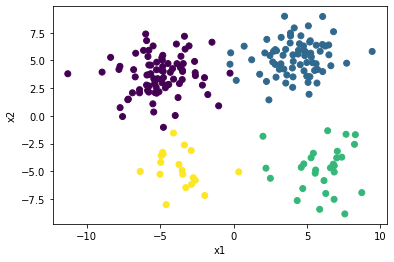

In [18]:
dataset = loadData('cluster_data_dataA_X', 'a')
Y, K = Gussian_mean_shift(dataset, 1.6)
plt.scatter(dataset[0, :], dataset[1, :], c=Y)                
plt.xlabel('x1')
plt.ylabel('x2')
# plt.title('{} data{}'.format(model_name,data))
plt.show()

In [6]:
def plot_1b():
    for model_name in ['Kmeans', 'GMM', 'Mean-shift']:
        plt.figure(figsize=(13,4))
        for i in range(1,4):
            plt.subplot(1,3,i)
            if i==1:data='A' 
            elif i==2:data='B' 
            else:data='C'
            dataset = loadData('cluster_data_data{}_X'.format(data), 'a')
            if model_name == 'Kmeans':
                Y, C = Kmeans(dataset, 4)
            elif model_name == 'GMM':
                Y, mu, Cov_mat, Pi, respon = EM_model(dataset, 4)
            elif model_name == 'Mean-shift':
                Y, K = Gussian_mean_shift(dataset, 1.6)
            plt.scatter(dataset[0, :], dataset[1, :], c=Y)                
            plt.xlabel('x1')
            plt.ylabel('x2')
            plt.title('{} data{}'.format(model_name,data))
        plt.tight_layout()
        plt.show()

In [11]:
def plot_1c(h_list):
    for data_name in ['dataA', 'dataB', 'dataC']:
        plt.figure(figsize=(13,8))
        for i in range(len(h_list)):
            plt.subplot(2,3, i+1)
            dataset = loadData('cluster_data_{}_X'.format(data_name), 'a')
            Y, K = Gussian_mean_shift(dataset, h_list[i])
            plt.scatter(dataset[0, :], dataset[1, :], c=Y)
            plt.xlabel('x1')
            plt.ylabel('x2')
            plt.title('{} with h={}'.format(data_name, h_list[i]))
            plt.tight_layout()
        plt.show()

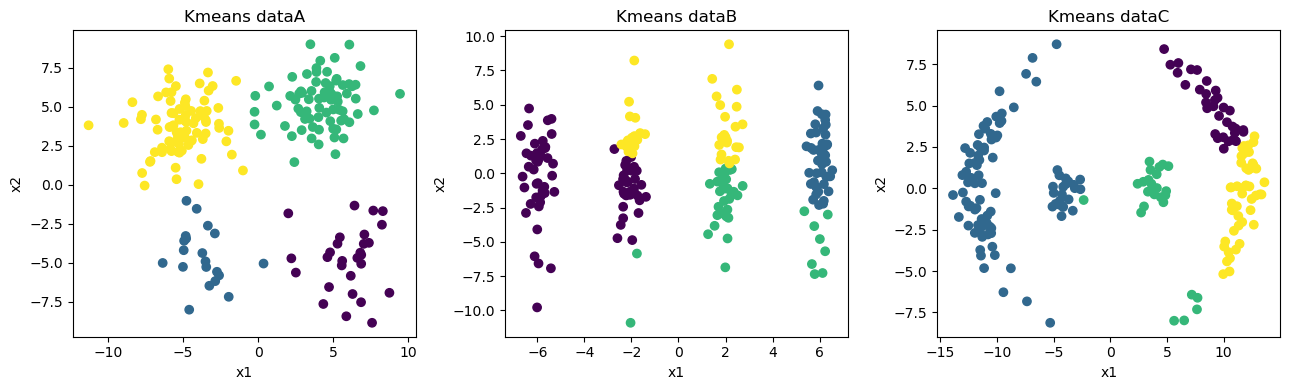

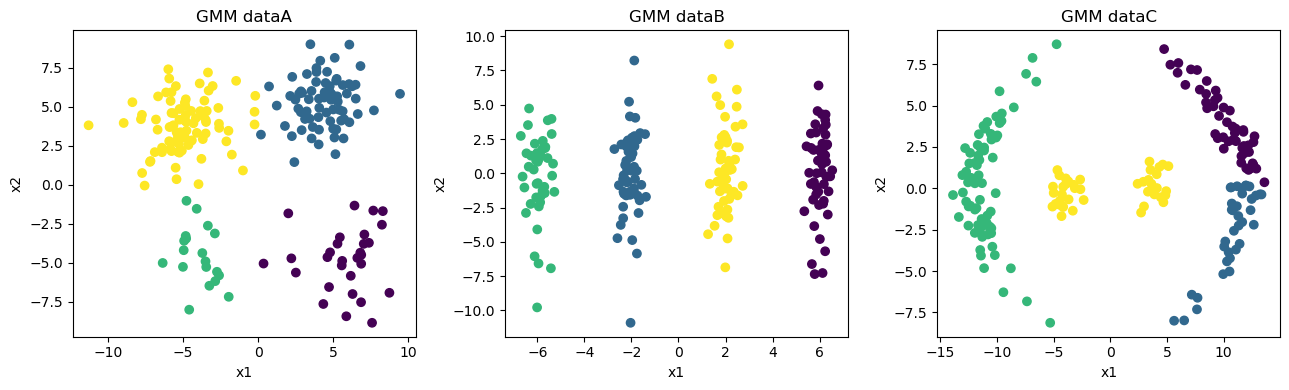

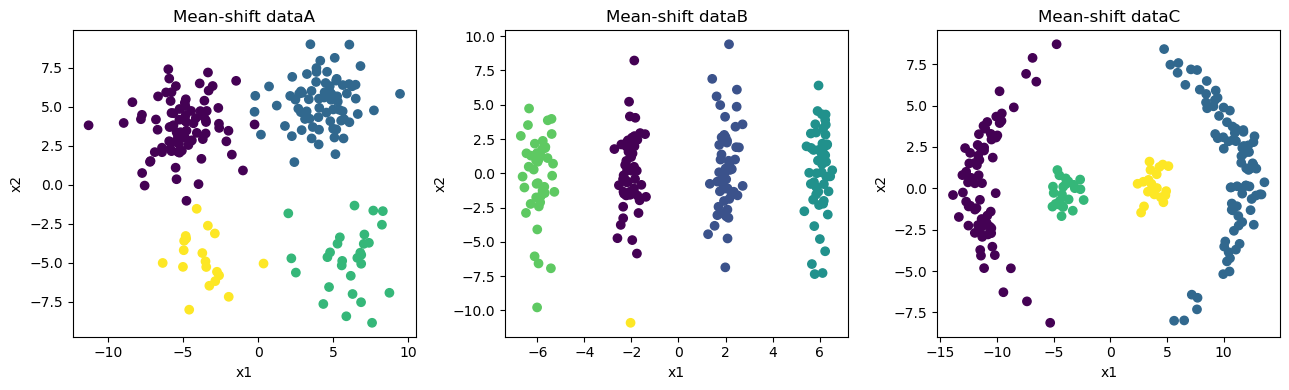

In [705]:
plot_1b()

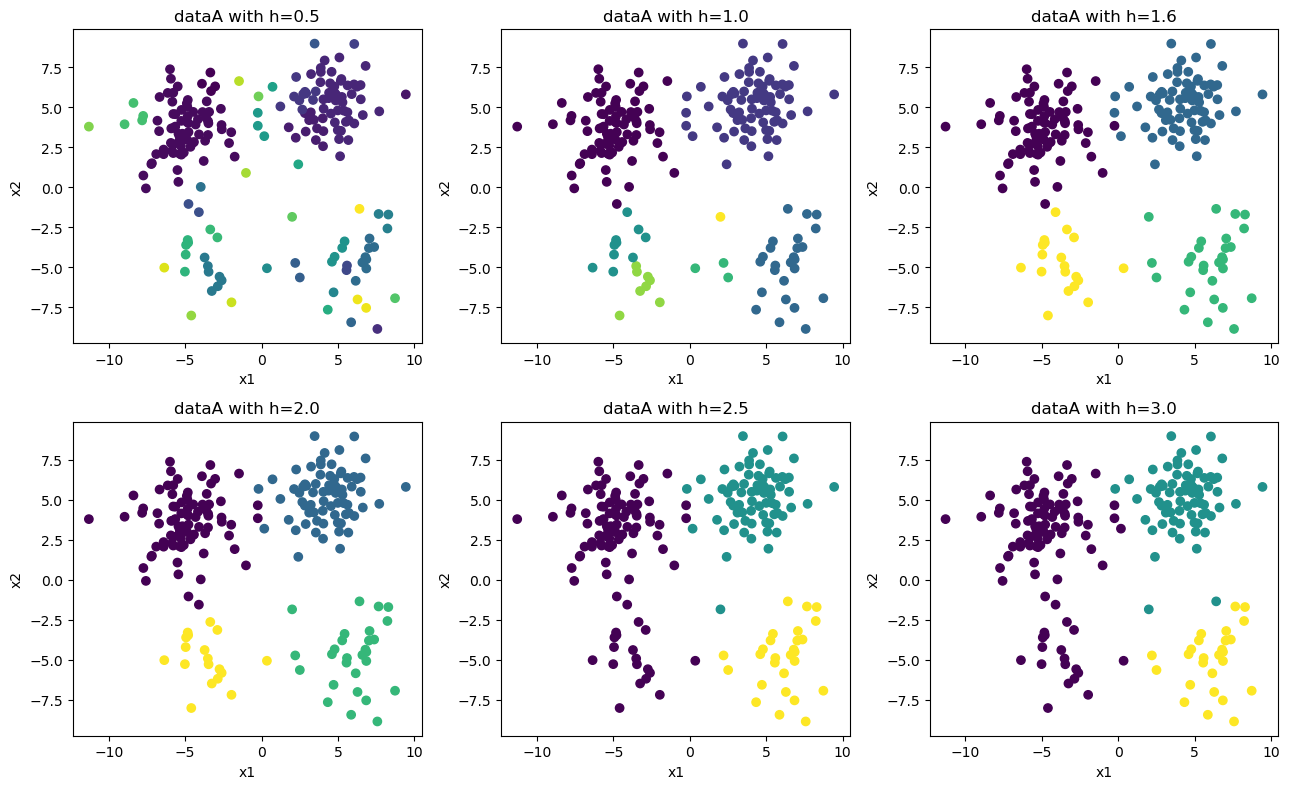

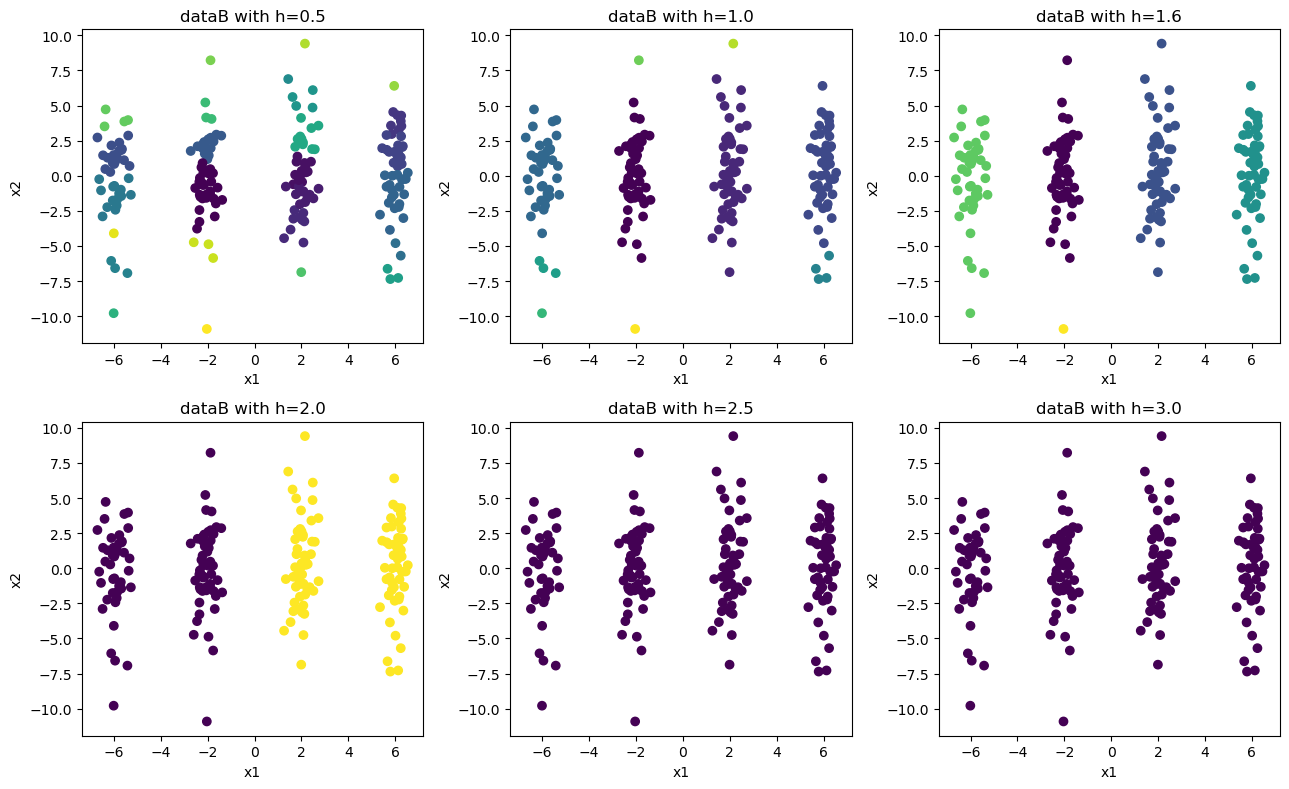

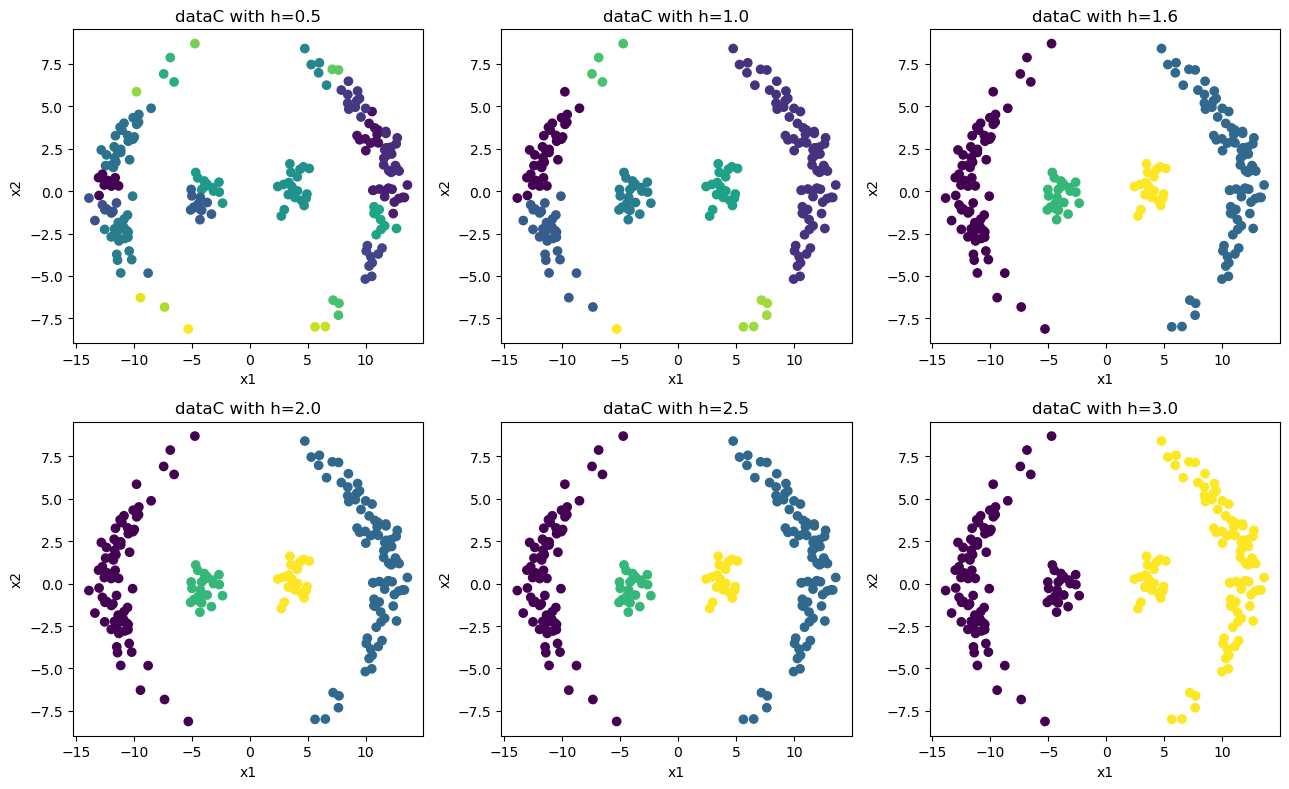

In [12]:
plot_1c([0.5, 1.0, 1.6, 2.0, 2.5, 3.0])

In [30]:
def plot_2a_1(filename='12003',K=[2, 4, 6, 8]):
    img = Image.open('images/{}.jpg'.format(filename))
    dataset, L = loadData(filename, 'b', img=img)
    for model_name in ['Kmeans', 'GMM']:
        for k in K:
            plt.figure(figsize=(12,4))
            plt.subplot(1,3,1)
            plt.imshow(img)
            if model_name == 'Kmeans':
                Y, C = Kmeans(dataset, k)
            elif model_name == 'GMM':
                Y, mu, Cov_mat, Pi, respon = EM_model(dataset, k)
            Y = Y + 1
            segm = pa2.labels2seg(Y,L)
            plt.subplot(1,3,2)
            plt.title('{}, k={}'.format(model_name, k))
            plt.imshow(segm)
            csegm = pa2.colorsegms(segm, img)
            plt.subplot(1,3,3)
            plt.imshow(csegm)   
            plt.tight_layout()
            plt.show()

In [36]:
def plot_2a_2(filename='12003',H=[0.2, 0.6, 1.0, 1.4]):
    img = Image.open('images/{}.jpg'.format(filename))
    dataset, L = loadData(filename, 'b', img=img)
    for h in H:
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(img)
        Y, K = Gussian_mean_shift(dataset, h)
        Y = Y + 1
        segm = pa2.labels2seg(Y,L)
        plt.subplot(1,3,2)
        plt.title('Mean-shift, h={}'.format(h))
        plt.imshow(segm)
        csegm = pa2.colorsegms(segm, img)
        plt.subplot(1,3,3)
        plt.imshow(csegm)   
        plt.tight_layout()
        plt.show()


Y, C = Kmeans(dataset, k, scale=1, lbda=0.1)

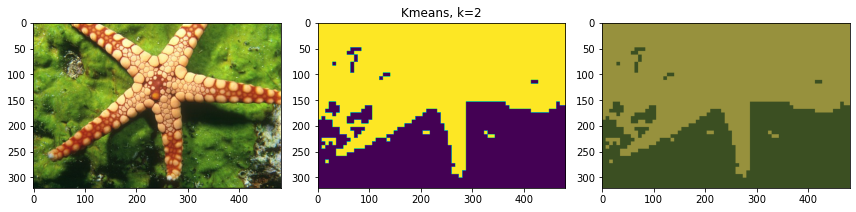

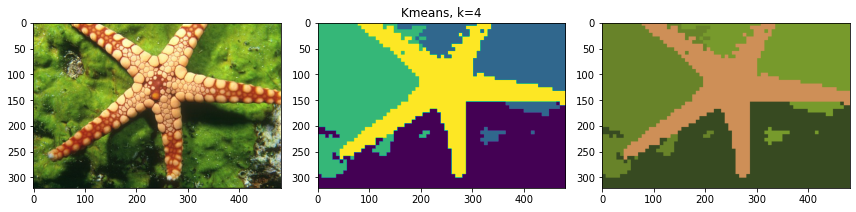

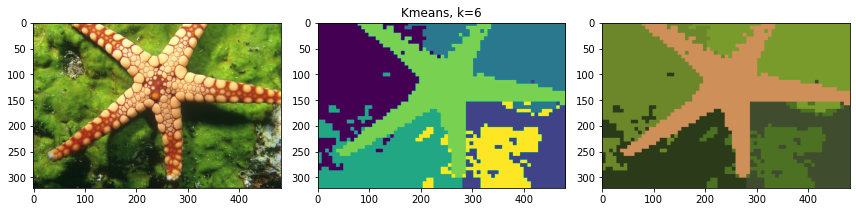

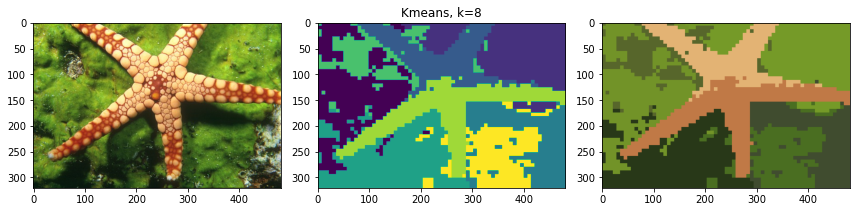

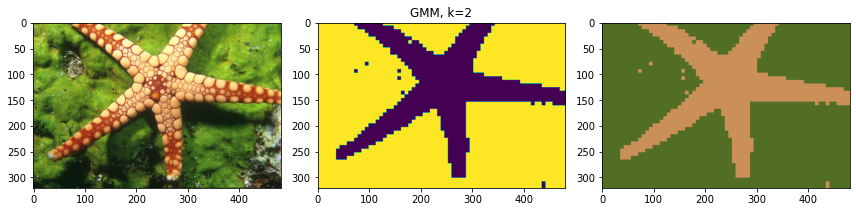

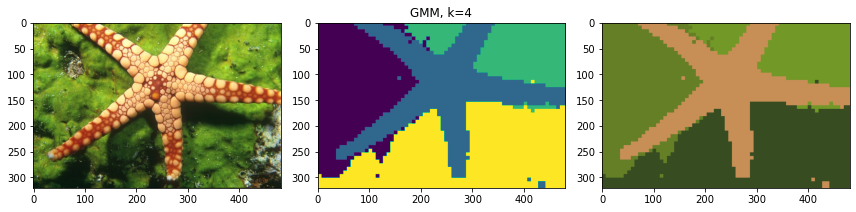

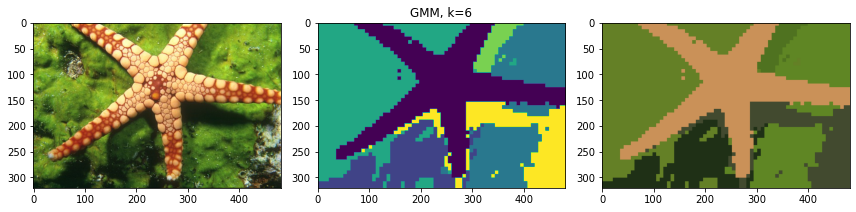

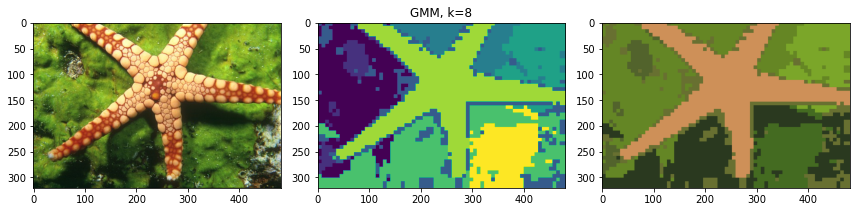

In [27]:
plot_2a_1()

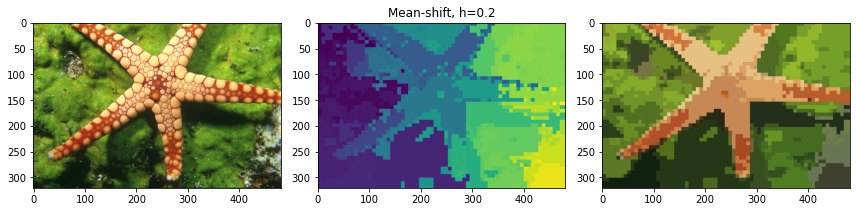

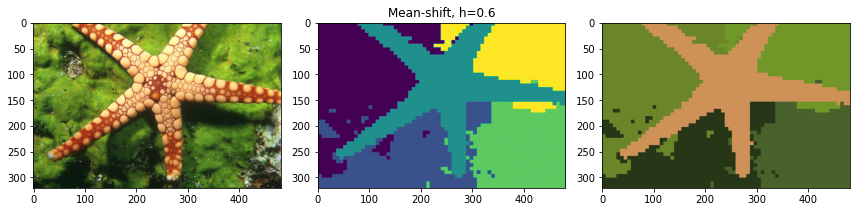

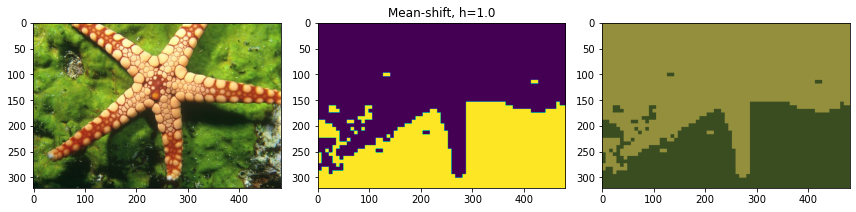

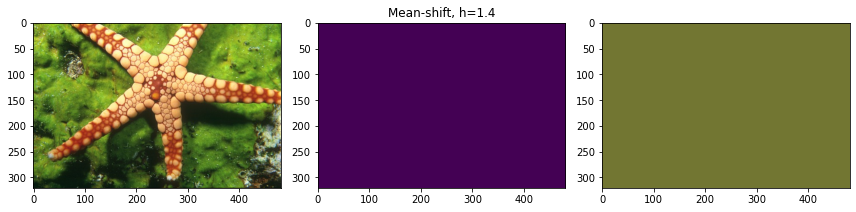

In [28]:
plot_2a_2()

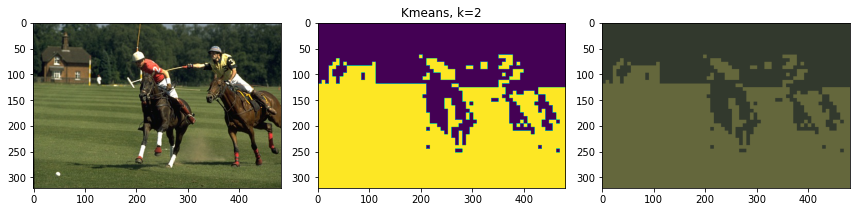

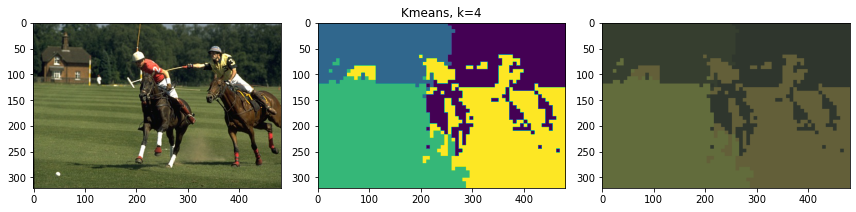

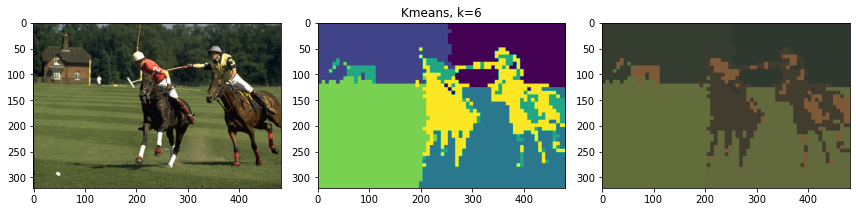

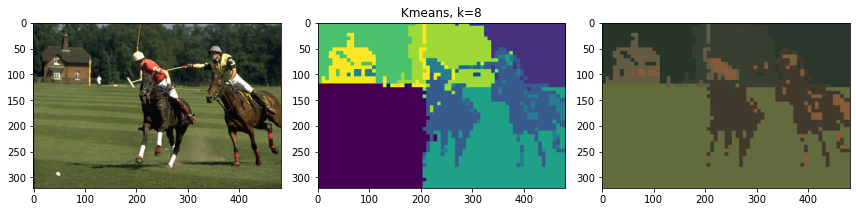

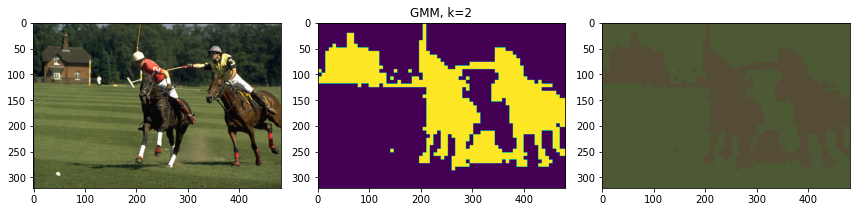

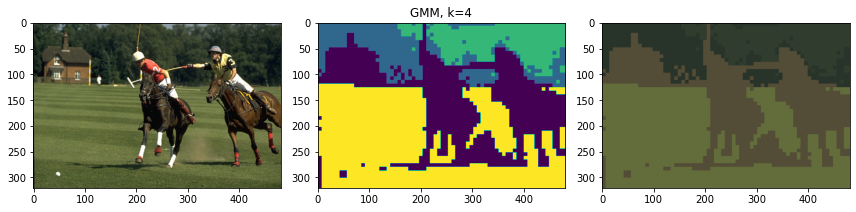

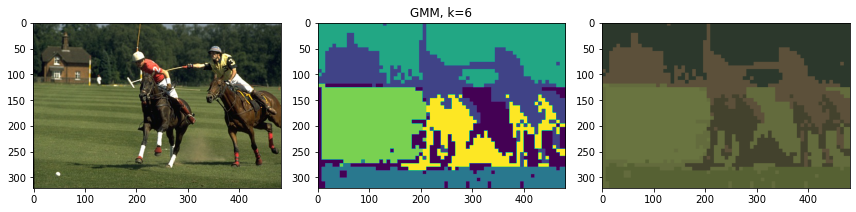

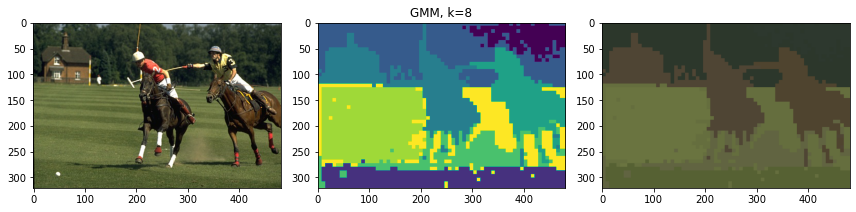

In [35]:
plot_2a_1(filename='361010',K=[2, 4, 6, 8])

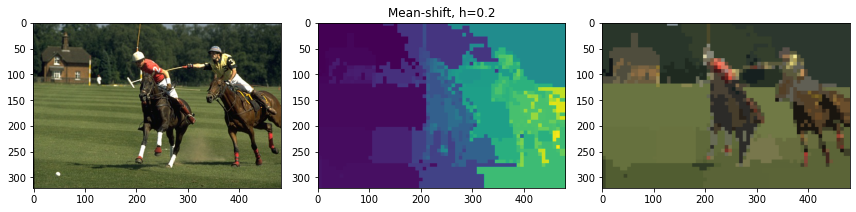

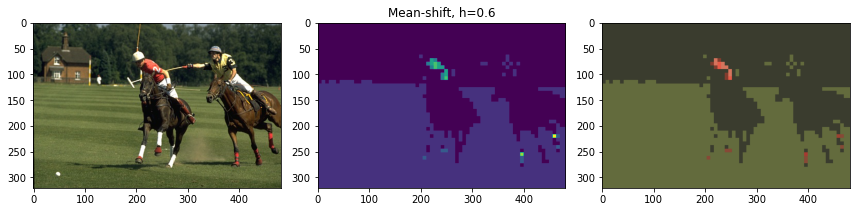

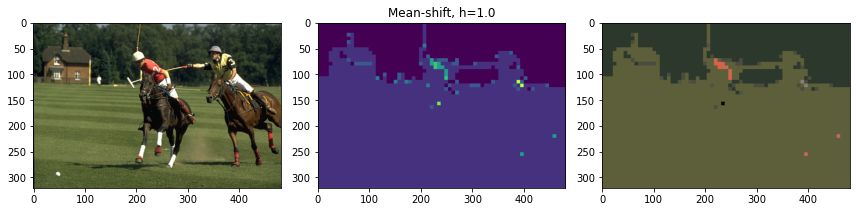

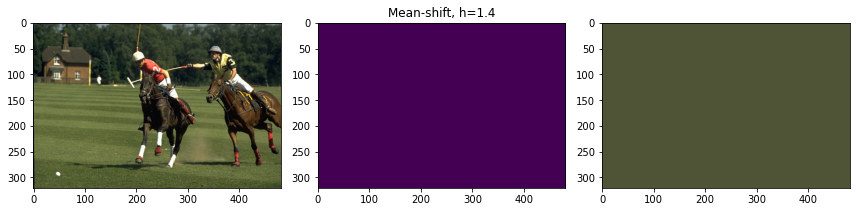

In [38]:
plot_2a_2(filename='361010',H=[0.2, 0.6, 1.0, 1.4])